In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

/uscms_data/d3/ekoenig/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [12]:
data = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [13]:
def preprocess(tree):
  h_dm = ak_stack([ np.abs(tree[f'{h}_m']-125) for h in eightb.higgslist])
  h_max_dm = ak.max(h_dm, axis=-1)

  btags = ak_stack([ tree[f'{b}_btag'] for b in eightb.quarklist ])
  n_medium_btag = ak.sum( btags>jet_btagWP[2], axis=-1)
  tree.extend(h_max_dm=h_max_dm,n_medium_btag=n_medium_btag)
data.apply(preprocess)

[None]

In [29]:
feature_names = ['X_m','X_pt','X_eta','X_phi']
rs = {"a":lambda t : (t.n_medium_btag >= 4) & (t.h_max_dm < 20),
    "b":lambda t : (t.n_medium_btag <  4) & (t.h_max_dm < 20),
    "c":lambda t : (t.n_medium_btag >= 4) & (t.h_max_dm > 20),
    "d":lambda t : (t.n_medium_btag <  4) & (t.h_max_dm > 20),}

In [30]:
X = 
W = data['scale'].cat

In [31]:
R = { r:data.apply(r_).cat for r,r_ in rs.items() }

In [36]:
get_r = lambda r: (X[R[r]], W[R[r]])

In [38]:
x_a, w_a = get_r('a')
x_b, w_b = get_r('b')
x_c, w_c = get_r('c')
x_d, w_d = get_r('d')


In [56]:
from hep_ml import reweight

class BDT:
  def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=2, min_samples_leaf=100, gb_args={'subsample':0.4}, n_folds=2):
    np.random.seed(1234) #Fix any random seed using numpy arrays

    reweighter_base = reweight.GBReweighter(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        gb_args=gb_args)

    self.reweighter = reweight.FoldingReweighter(reweighter_base, random_state=1234, n_folds=n_folds, verbose=False)
  
  def train(self, targ_x, targ_w, estm_x, estm_w):
    self.k_factor = ak.sum(targ_w)/ak.sum(estm_w)
    self.reweighter.fit(targ_x, estm_x, targ_w, self.k_factor*estm_w)

  def eval(self, x, w):
    return self.reweighter.predict_weights(x,self.k_factor*w,lambda x: np.mean(x, axis=0))


In [57]:
bdt = BDT()

In [58]:
bdt.train(x_c, w_c, x_d, w_d)

In [59]:
bdt.eval(x_d, w_d)

array([5.73919499e-03, 8.20138240e-04, 5.47960359e-04, ...,
       2.36548541e-07, 8.20368434e-08, 7.35037132e-08])

In [78]:
def tree_bdt(tree):
  x = ak_stack([ tree[feature] for feature in feature_names ])
  w = tree['scale']
  k_w = bdt.eval(x, w)
  return k_w/w

def tree_k_factor(tree):
  w = tree['scale']
  k_w = bdt.k_factor*w
  return k_w/w

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


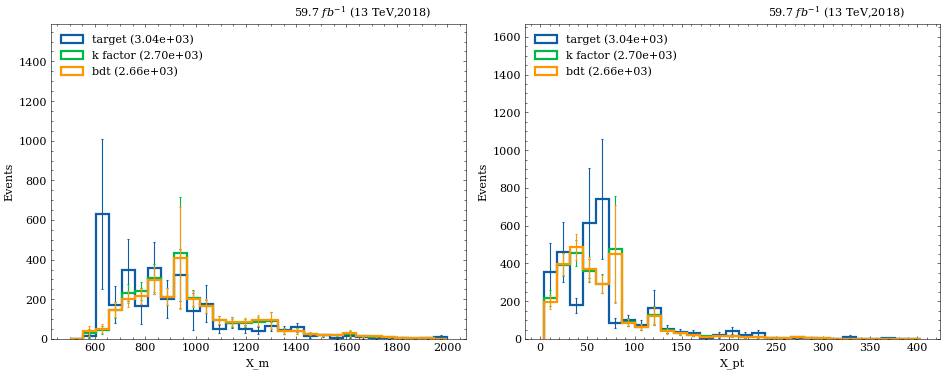

In [81]:
study.quick(
  data+data+data, h_color=None, label=['target','k factor','bdt'], legend=True,
  scale=[None, tree_k_factor, tree_bdt],
  masks=[R['a'], R['b'], R['b']],

  varlist=['X_m','X_pt']
)